# Afeka - ML3 - Titanic

Noam Levi  
205530611  
[Kaggle Profile](https://www.kaggle.com/noamlevi)

## Introduction

We're going to be working on the [Titanic dataset](https://www.kaggle.com/c/titanic/data) from the [kaggle competition](https://www.kaggle.com/c/titanic).  

This is a continued work from `Assignment1`.

---

Roadmap:
- [Data Exploration](#Data-Exploration) and Data Visualising - *from `Assignment1`*
- [Data Cleaning](#Data-Cleaning), handling missing data in our df using different methods - *from `Assignment1`*
- [Feature Engineering](#Feature-Engineering), creating/choosing the right features for a better ML model - *from `Assignment1`*
- [Training & Model Comparing](#Training-&-Model-Comparing), Fitting a linear model & loss function plotting using different hyperparameters
- [Testing](#Testing)
- [Summary](#Summary)
- [References](#References)

## Imports

In [1]:
from IPython.display import display, Markdown
import random
import math
import pandas as pd
# from pandas_profiling import ProfileReport
import sweetviz as sv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
#from scipy import stats
from sklearn import metrics
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, Normalizer #, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import LeavePOut, KFold, GridSearchCV, cross_validate, train_test_split
# from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier as KnnClassifier
from sklearn.naive_bayes import GaussianNB as GaussianNBC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDAClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier


sns.set_style("darkgrid")
# plt.style.use("fivethirtyeight")

Joining `train` & `test` to a single `data` df for an easier time while working on the model.

In [2]:
index_col = 'PassengerId'
train = pd.read_csv('../data/train.csv', index_col=index_col)
test = pd.read_csv('../data/test.csv', index_col=index_col)

ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat([train, test]).reset_index(drop=True)

# data

In [3]:
# global pipeline
pipeline = Pipeline([(
    'none',
    FunctionTransformer(func=None)
)])


## use pipeline.steps.append() for adding steps ##

In [4]:
def appendToPipeline(pipeline, funcs):
    """An overly complicated function for appending steps to a pipeline
    \nfuncs = [('name1', func1), func2, func3, ...]"""
    names = []
    for (n,f) in pipeline.steps:
        names += [n]

    if not isinstance(funcs, (list,tuple)):
        funcs = [funcs]
    
    for step in funcs:
        func = None
        name = None
        if isinstance(step, (list,tuple)):
            name = step[0]
            func = step[1]
        else:
            func = step
        
        if name == None:
            name = func.__name__
        
        func = FunctionTransformer(func)
        if name not in names:
            pipeline.steps.append( (name,func) )
        else:
            i = names.index(name)
            pipeline.steps[i] = (name,func)

## Data Exploration

In [5]:
aggs = list()
survivors = train[train['Survived']==1]

for col in train.columns:
    if col != 'Survived':
        aggs.append( survivors[['Survived', col]].groupby(col).agg('count').reset_index() )

To start thing off, we can use ~~pandas_profiling~~ sweetviz library to get an overview of the entire training dataset.

In [6]:
# data.head()

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



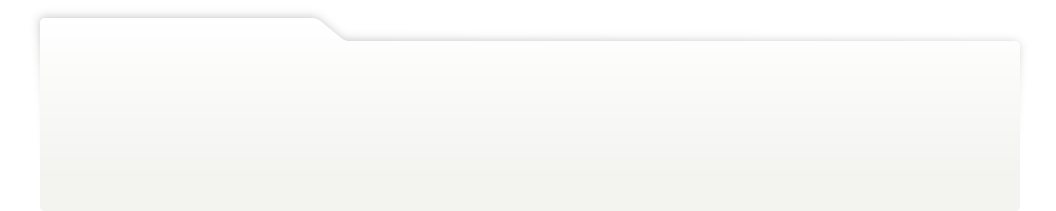
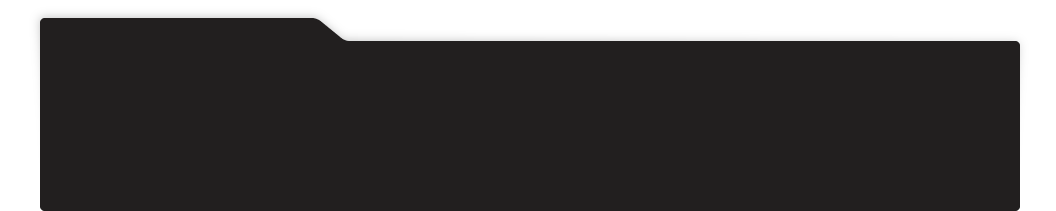
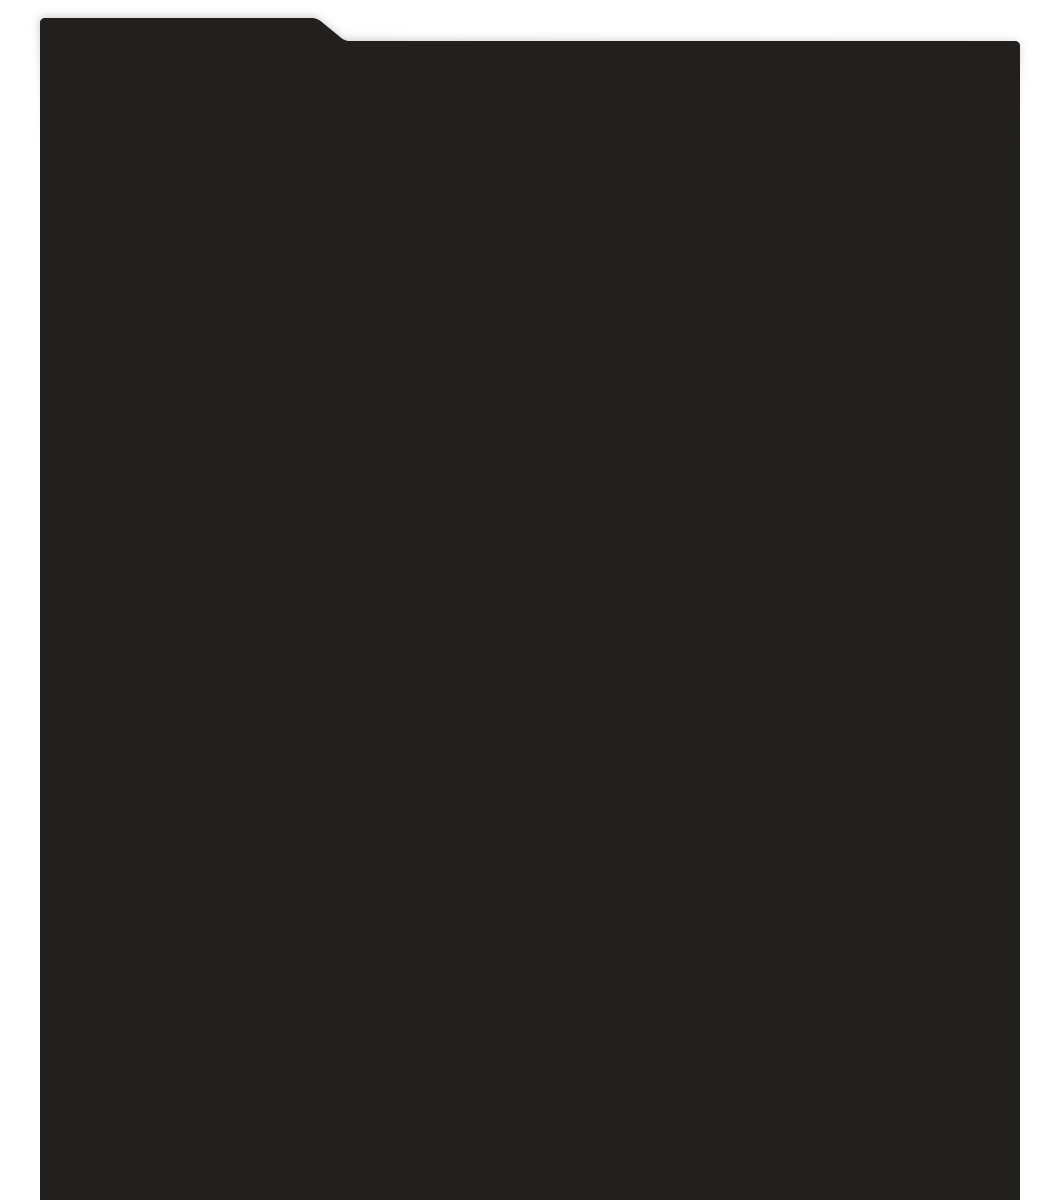
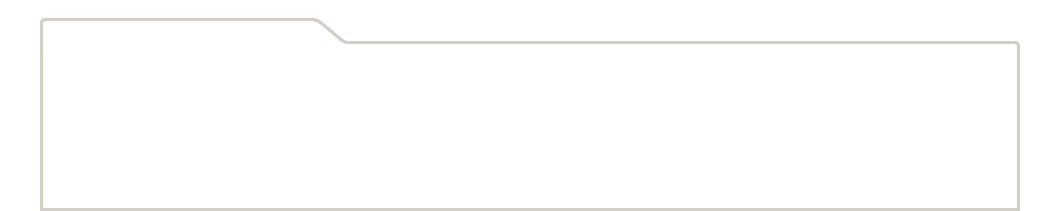
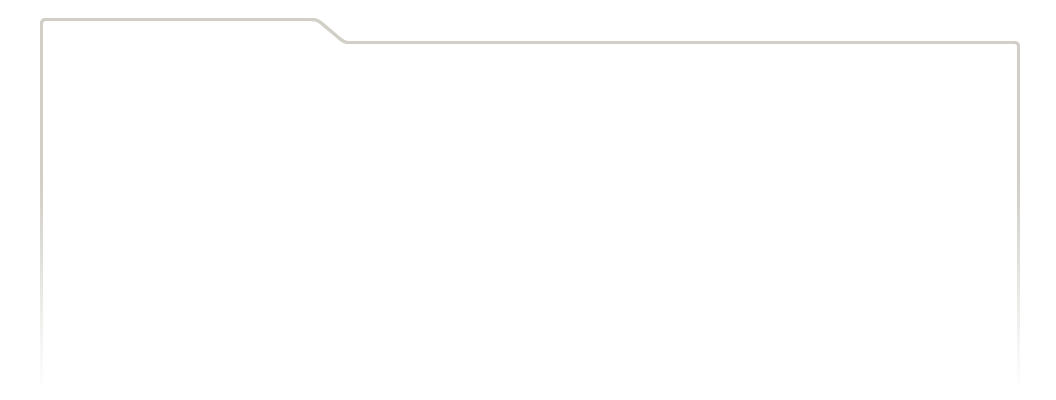
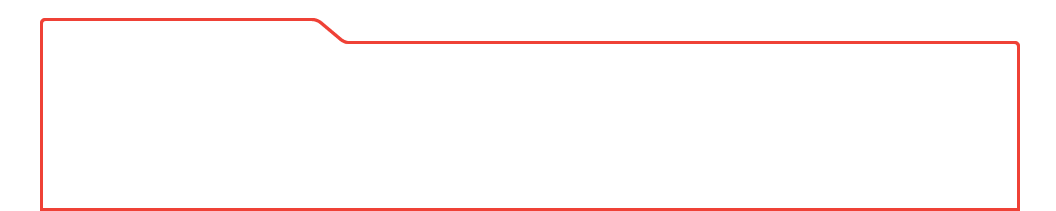
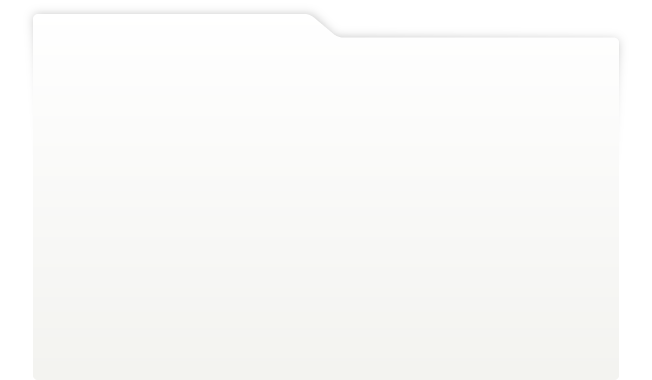
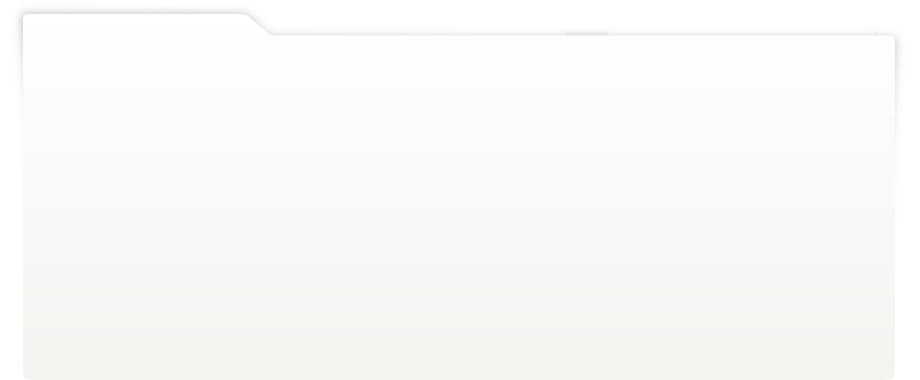
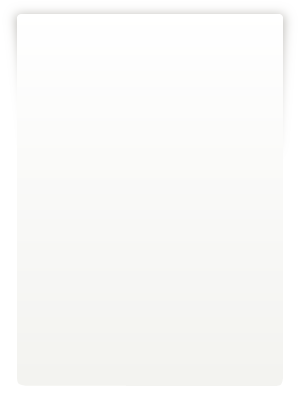
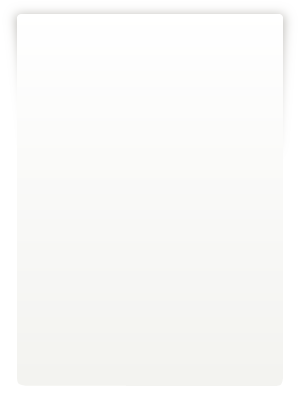
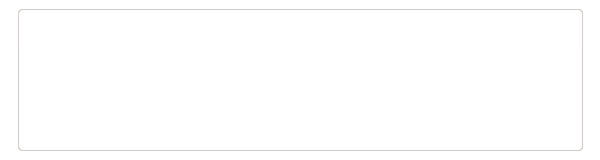
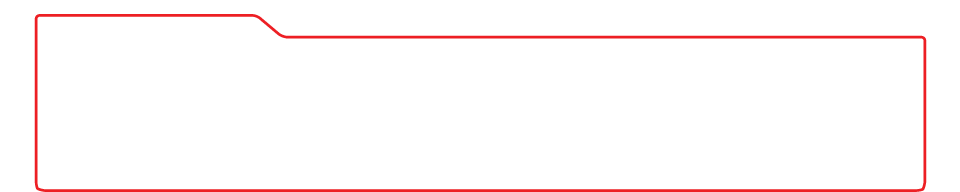
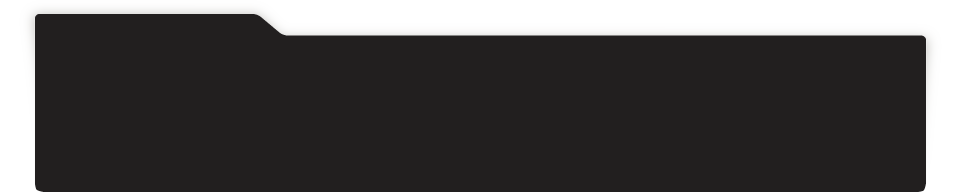
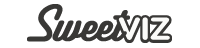
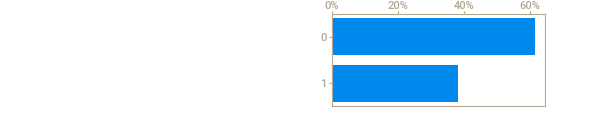
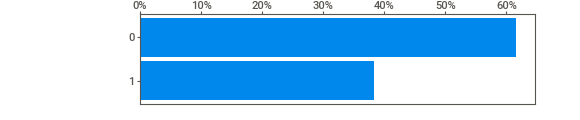
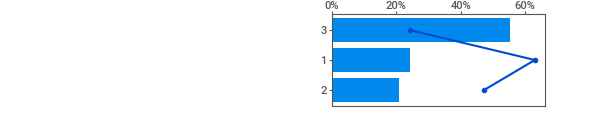
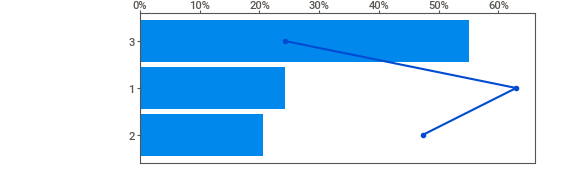
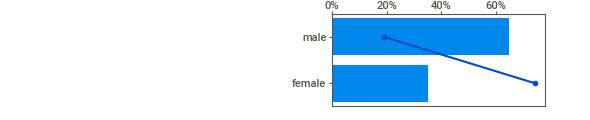
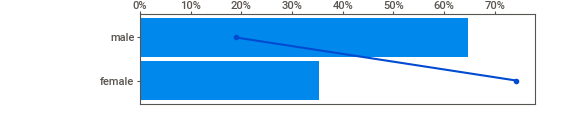
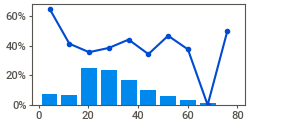
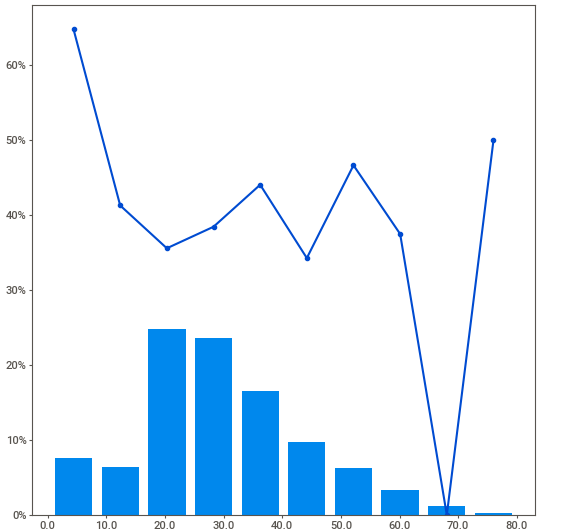
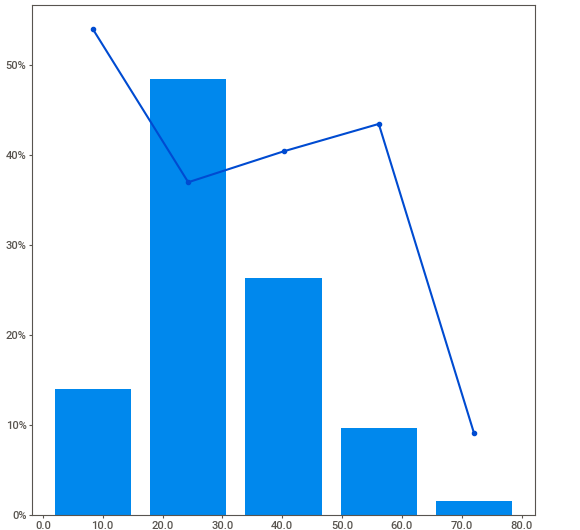
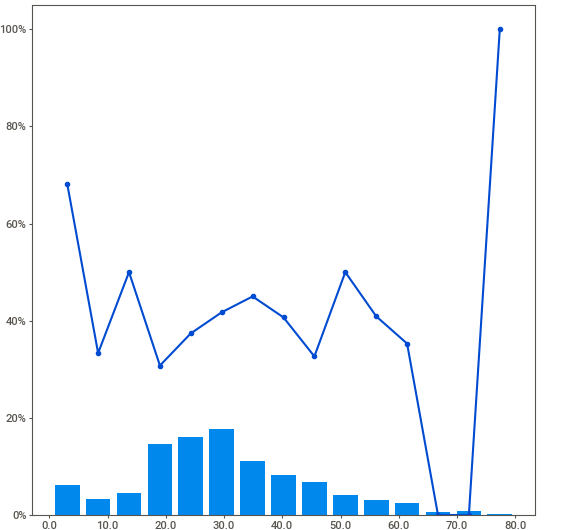
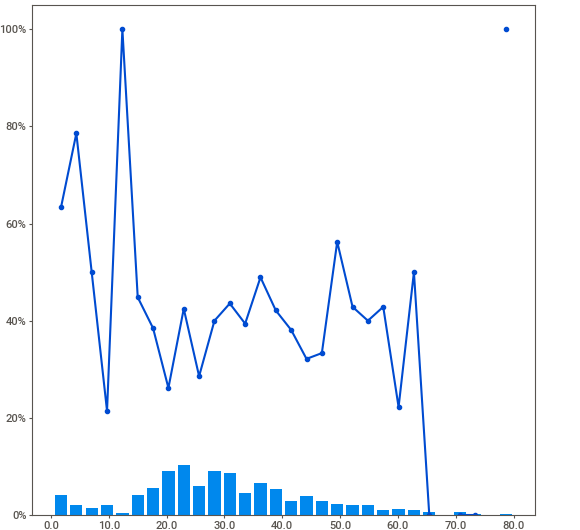
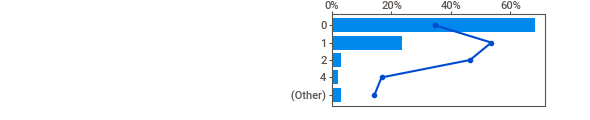
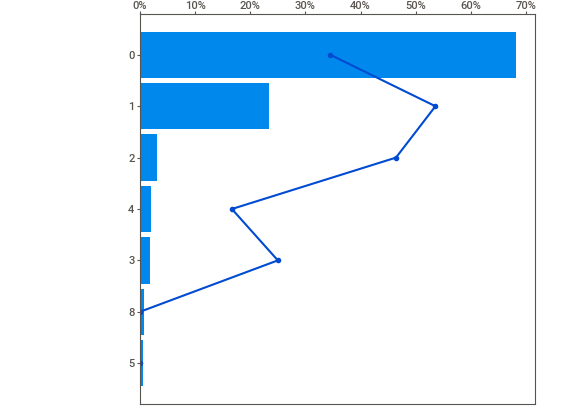
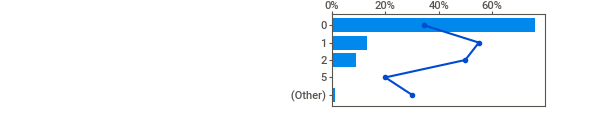
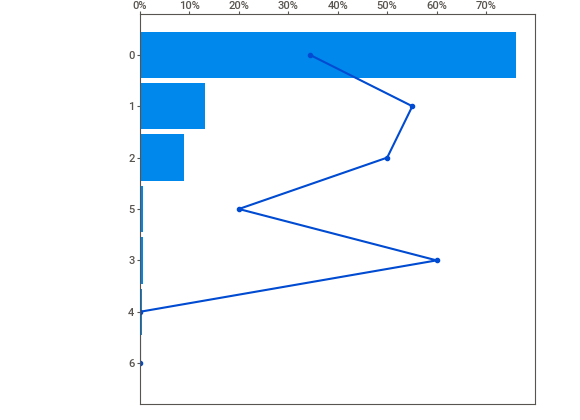
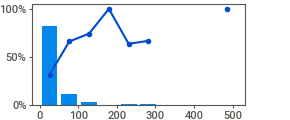
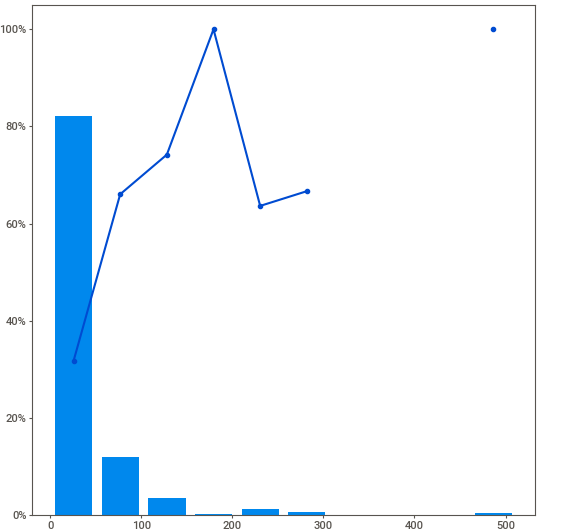
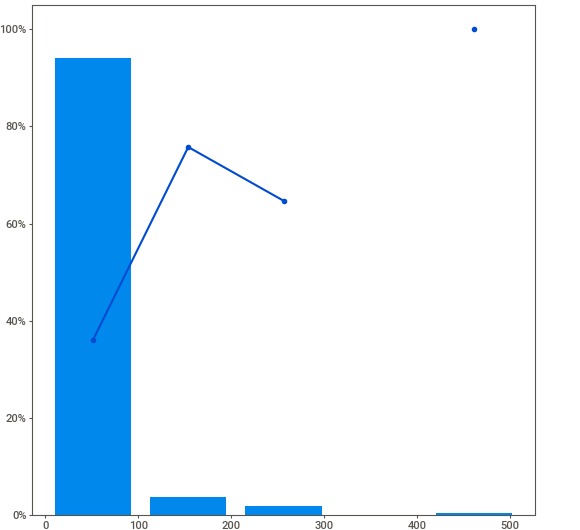
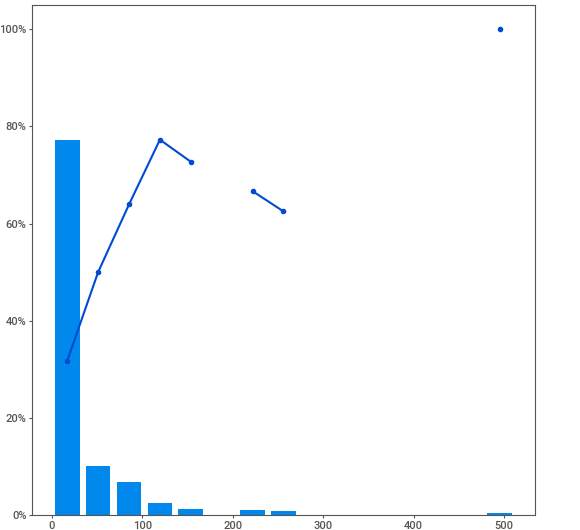
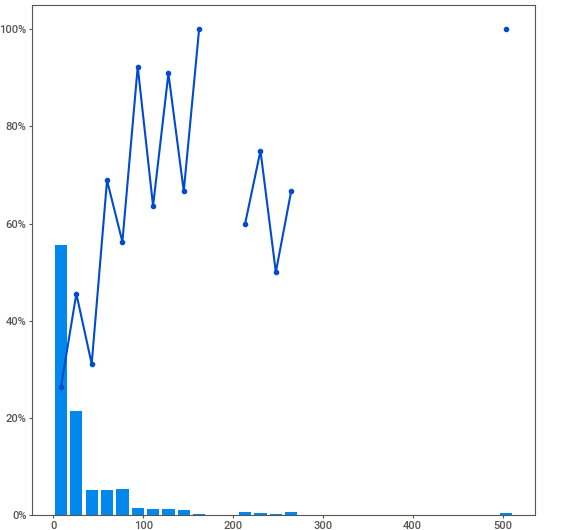
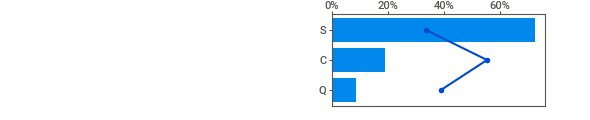
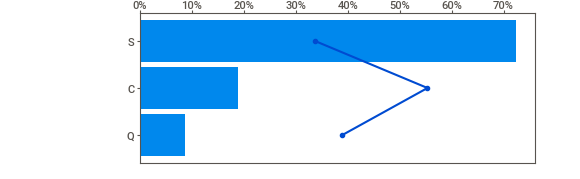
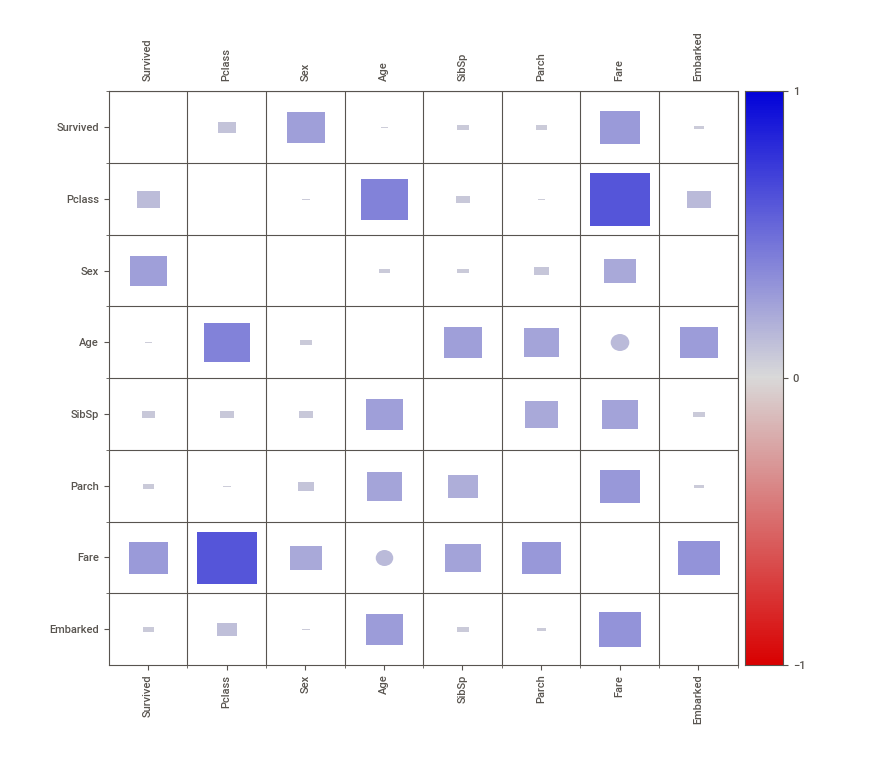
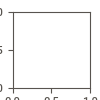

In [7]:
report = sv.analyze(train, target_feat='Survived')
report.show_notebook()

In [8]:
sns.set_style('darkgrid')

display(data.head())

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's take a look at the target value's distribution.

Text(0.5, 1.0, 'Survivors by Sex')

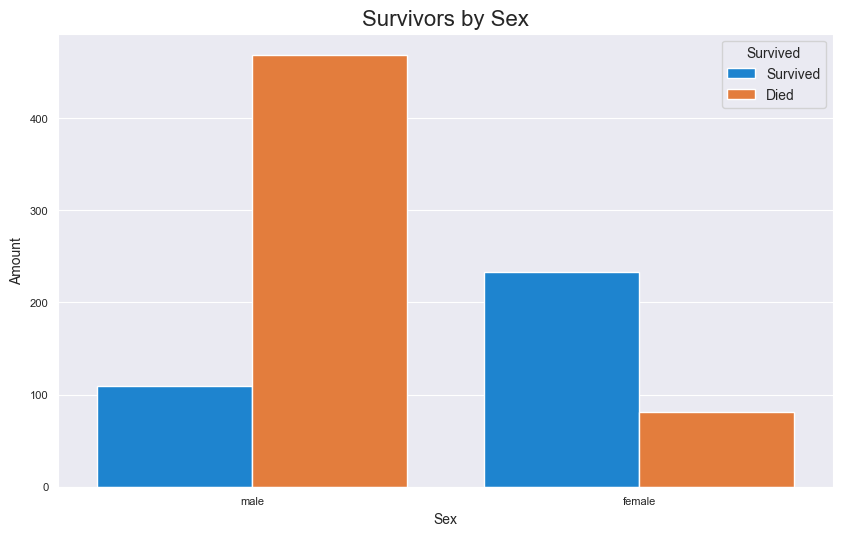

In [9]:
survived_per_sex = pd.DataFrame()
survived_per_sex['Sex'] = ['female','male']*2
survived_per_sex['Survived'] = ['Survived']*2 + ['Died']*2
survived_per_sex['Amount'] = (
    list(train[train['Survived']==1].groupby('Sex').agg('count')['Survived']) +
    list(train[train['Survived']==0].groupby('Sex').agg('count')['Survived'])
)

# survived_per_sex
plt.subplots(figsize=(10,6))
ax = sns.barplot(x='Sex', y='Amount', hue='Survived', order=['male', 'female'], data=survived_per_sex)
ax.set_title('Survivors by Sex', fontsize=16)

The next interesting graph would be survival rate per age group.

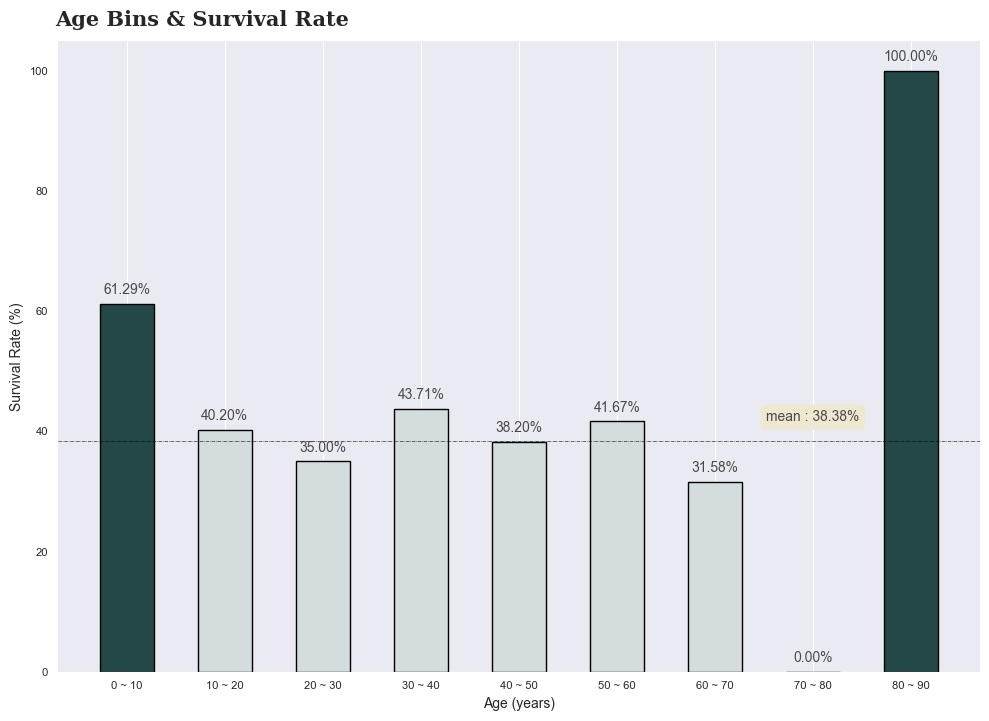

In [10]:
def age_bin(num):
    for i in range(1, 100):
        if num < 10*i :  return f'{(i-1) * 10} ~ {i*10}'

tmp = train.copy()

tmp['age_bin'] = tmp['Age'].apply(age_bin)
titanic_age = tmp[['age_bin', 'Survived']].groupby('age_bin')['Survived'].value_counts().sort_index().unstack().fillna(0)
titanic_age['Survival rate'] = titanic_age[1] / (titanic_age[0] + titanic_age[1]) * 100

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# ax2
color_map = ['#d4dddd' for _ in range(9)]
color_map[0] = color_map[8] = '#244747'

ax.bar(titanic_age['Survival rate'].index, titanic_age['Survival rate'], 
       color=color_map, width=0.55, 
       edgecolor='black', 
       linewidth=1)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)

for i in titanic_age['Survival rate'].index:
    ax.annotate(f"{titanic_age['Survival rate'][i]:.02f}%", 
                   xy=(i, titanic_age['Survival rate'][i] + 2.3),
                   va = 'center', ha='center',fontweight='light', 
                   color='#4a4a4a')

mean = tmp['Survived'].mean()*100
ax.axhline(mean ,color='black', linewidth=0.4, linestyle='dashdot')
ax.annotate(f"mean : {mean :.4}%", 
            xy=('70 ~ 80', mean + 4),
            va = 'center', ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))
    
    
fig.text(0.06, 1, 'Age Bins & Survival Rate', fontsize=15, fontweight='bold', fontfamily='serif')
ax.set_xlabel('Age (years)')
ax.set_ylabel('Survival Rate (%)')

grid_y_ticks = np.arange(0, 101, 20)
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y', linestyle='-', alpha=0.4)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Survivors by Age')

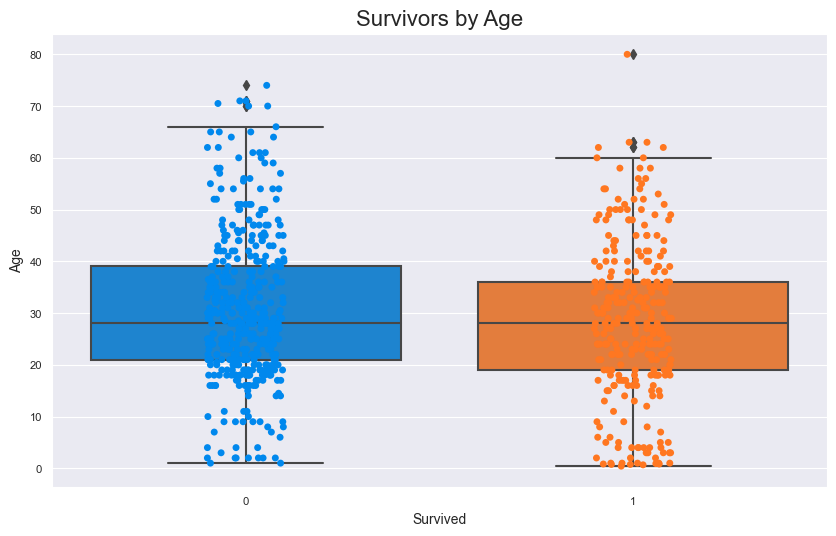

In [11]:
plt.subplots(figsize=(10,6))

ax = sns.boxplot(x="Survived", y="Age", data=train)
ax = sns.stripplot(x="Survived", y="Age", jitter=True, edgecolor="gray", data=train)

ax.set_title("Survivors by Age", fontsize=16)

From the barplot above, we can see that the infants and the elderly were prioritized to be saved.
For the rest of the age groups, the survival rate seems farily evenly distributed.

Text(0.5, 1.0, 'Fare vs Age')

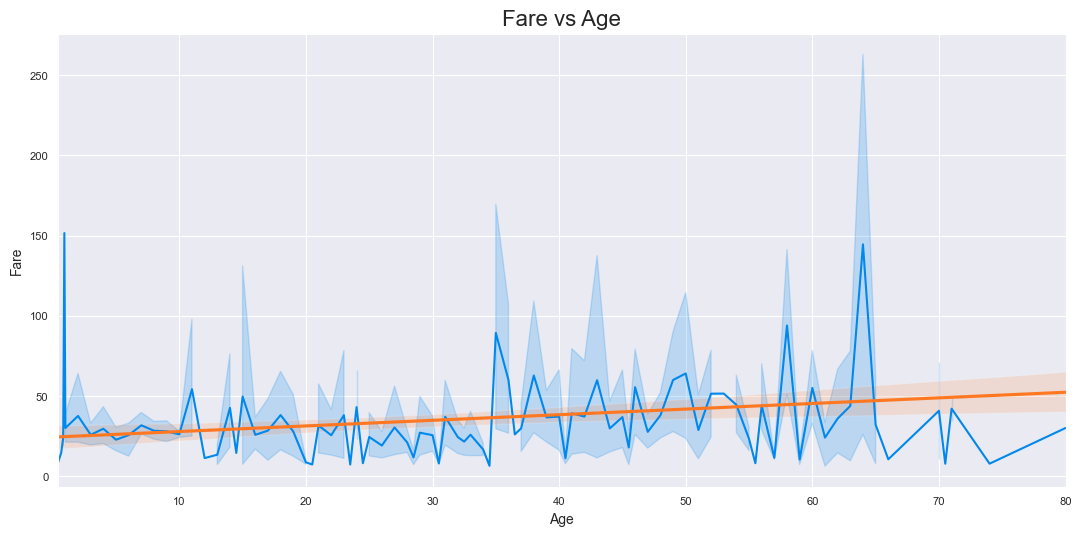

In [12]:
plt.figure(figsize=(13, 6))
sns.lineplot(x='Age', y='Fare', data=train)
sns.regplot(x='Age', y='Fare', data=train, scatter=False)
plt.title('Fare vs Age', fontsize=16)

The last thing we should visual is the correlation of different columns in our dataset, for easier understanding of which column affects which.

Text(0.5, 1.0, 'Correlation Between Features')

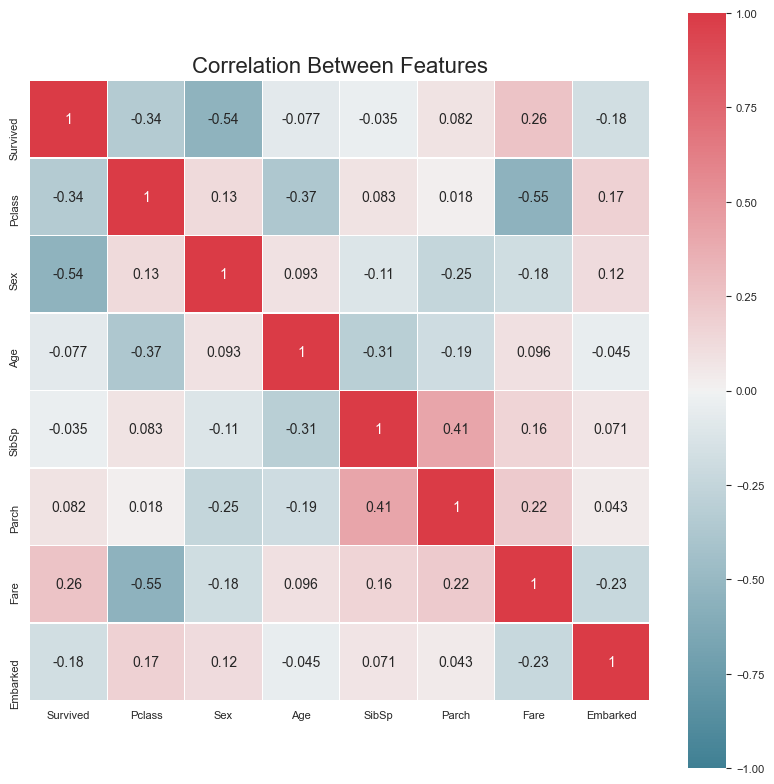

In [13]:
tmp = train.copy()
tmp['Sex'] = tmp['Sex'].astype('category').cat.codes
tmp['Embarked'] = tmp['Embarked'].astype('category').cat.codes
corr = tmp.corr()

plt.figure(figsize=(10, 10))
ax = sns.heatmap(corr, vmax=1, vmin=-1, linewidths=0.01, square=True, annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True), linecolor="white")
ax.set_title('Correlation Between Features', fontsize=16)

## Data Cleaning

We will copy the cleaning step from `Assignment1`'s notebook.

In [14]:
# def NAs(data):
data_na = (data.drop(columns=['Survived']).isnull().sum() / len(data)) * 100
# data_na = (data_dummy.drop(columns=['Survived']).isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing %': data_na})
missing_data.head()
# return missing_data

# NAs(train).head()

,Missing %
Cabin,77.463713
Age,20.091673
Embarked,0.152788
Fare,0.076394


In [15]:
def handle_cabin(df):
    df = df.copy()
    df['Cabin'].fillna('X', inplace=True)
    return df

def fix_na(df):
    df = df.copy()
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    df['Fare'].fillna(df['Fare'].median(), inplace=True) # for the test data, has missing values.
    return df

appendToPipeline(pipeline, [handle_cabin, fix_na])
data_filled = pipeline.fit_transform(data)

In [16]:
data_filled.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S


In [17]:
# data_filled.info()

## Feature Engineering

We will copy the feature engineering step from `Assignment1`'s notebook.

In [18]:
def str_to_cat(df):
    df = df.copy()
    cols = ['Embarked','Sex', 'Pclass']
    for col in cols:
        df[col] = df[col].astype('category').cat.codes.astype('category')
    return df

def norm_cols(df):
    def norm(col):
        max_col = np.max(col)
        min_col = np.min(col)
        return (col-min_col) / (max_col-min_col)
    
    df = df.copy()
    # df['Age'] = norm(df['Age'])
    # df['Fare'] = norm(df['Fare'])
    return df

def bin_cols(df):
    df = df.copy()
    df['Age'] = pd.cut(df['Age'], 10).cat.codes.astype('category')
    df['Fare'] = pd.qcut(df['Fare'], 13, duplicates='drop').cat.codes.astype('category')
    return df

def add_title_col(df):
    df = df.copy()
    df['Title'] = \
        df['Name'].str \
        .split(', ', expand=True)[1].str \
        .split(' ', expand=True)[0] \
        .apply(lambda val: val.strip('.'))
    
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    # df['Title'] = df['Title'].replace('Mrs', 'Miss') # keep miss instead of mrs
    
    titles = list(df['Title'].value_counts().where(df['Title'].value_counts() > 10).dropna().index)
    df['Title'] = df['Title'].apply(lambda title: title if title in titles else 'Else').astype('category')

    # Encoding `Title` as categorial int
    df['Title'] = df['Title'].astype('category').cat.codes.astype('category')
    df.drop(columns='Name', inplace=True)
    return df

def add_deck_col(df):
    df = df.copy()
    df['Deck'] = df['Cabin'].apply( lambda val: str(val)[0].upper() )
    df.drop(columns=['Cabin'], inplace=True)    
    
    df['Deck'] = df['Deck'].astype('category').cat.codes.astype('category')
    return df

def handle_ticket(df):
    df = df.copy()
    df['Ticket_Frequency'] = df.groupby('Ticket')['Ticket'].transform('count')
    df.drop(columns=['Ticket'], inplace=True)
    return df

def add_family_col(df):
    def family_map(size):
        if size < 2:
            return 'Alone'
        elif size <= 4:
            return 'Small'
        elif size <= 6:
            return 'Medium'
        else: # size > 6
            return 'Large'

    df = df.copy()
    df['FamilySize'] = 1 + df['SibSp'] + df['Parch']
    df['FamilySize'] = df['FamilySize'].apply(family_map)
    df['FamilySize'] = df['FamilySize'].astype('category').cat.codes.astype('category')
    df.drop(columns=['SibSp', 'Parch'], inplace=True)
    return df

def get_dummies(df):
    df = df.copy()
    df = pd.get_dummies(df)
    return df


In [19]:
appendToPipeline(
    pipeline,
    [
        str_to_cat,
        norm_cols,
        bin_cols,
        add_title_col,
        add_deck_col,
        handle_ticket,
        add_family_col,
        get_dummies,
    ]
)

In [20]:
data_dummy = pipeline.fit_transform(data)
data_dummy

,Survived,Ticket_Frequency,Pclass_0,Pclass_1,Pclass_2,Sex_0,Sex_1,Age_0,Age_1,Age_2,...,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Deck_8,FamilySize_0,FamilySize_1,FamilySize_2,FamilySize_3
0,0.0,1,0,0,1,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
1,1.0,2,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1.0,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,1.0,2,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1305,NaN,3,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1306,NaN,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1307,NaN,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [21]:
data_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 51 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Survived          891 non-null    float64
 1   Ticket_Frequency  1309 non-null   int64  
 2   Pclass_0          1309 non-null   uint8  
 3   Pclass_1          1309 non-null   uint8  
 4   Pclass_2          1309 non-null   uint8  
 5   Sex_0             1309 non-null   uint8  
 6   Sex_1             1309 non-null   uint8  
 7   Age_0             1309 non-null   uint8  
 8   Age_1             1309 non-null   uint8  
 9   Age_2             1309 non-null   uint8  
 10  Age_3             1309 non-null   uint8  
 11  Age_4             1309 non-null   uint8  
 12  Age_5             1309 non-null   uint8  
 13  Age_6             1309 non-null   uint8  
 14  Age_7             1309 non-null   uint8  
 15  Age_8             1309 non-null   uint8  
 16  Age_9             1309 non-null   uint8  


In [22]:
# pipeline.steps

Now we can split our `data` back into `train` and `test`

In [23]:
def df_to_train_test(df):
    df = df.copy()
    train_dummy = df[:ntrain]
    train_dummy['Survived'] = train_dummy['Survived'].astype('uint8')    
    
    test_dummy = df[ntrain:]
    test_dummy = test_dummy.drop(columns=['Survived'])
    test_dummy.index = test.index

    return (train_dummy, test_dummy)

appendToPipeline(pipeline, df_to_train_test)

In [24]:
(train_dummy, test_dummy) = pipeline.fit_transform(data)

# train_dummy = data_dummy[:ntrain]
# train_dummy['Survived'] = train_dummy['Survived'].astype('uint8')

# test_dummy = data_dummy[ntrain:].drop(columns=['Survived'])
# test_dummy.index = test.index

display(train_dummy)
# display(test_dummy)

,Survived,Ticket_Frequency,Pclass_0,Pclass_1,Pclass_2,Sex_0,Sex_1,Age_0,Age_1,Age_2,...,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Deck_8,FamilySize_0,FamilySize_1,FamilySize_2,FamilySize_3
0,0,1,0,0,1,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
1,1,2,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,1,2,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
887,1,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
888,0,4,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
889,1,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [25]:
train_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 51 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Survived          891 non-null    uint8
 1   Ticket_Frequency  891 non-null    int64
 2   Pclass_0          891 non-null    uint8
 3   Pclass_1          891 non-null    uint8
 4   Pclass_2          891 non-null    uint8
 5   Sex_0             891 non-null    uint8
 6   Sex_1             891 non-null    uint8
 7   Age_0             891 non-null    uint8
 8   Age_1             891 non-null    uint8
 9   Age_2             891 non-null    uint8
 10  Age_3             891 non-null    uint8
 11  Age_4             891 non-null    uint8
 12  Age_5             891 non-null    uint8
 13  Age_6             891 non-null    uint8
 14  Age_7             891 non-null    uint8
 15  Age_8             891 non-null    uint8
 16  Age_9             891 non-null    uint8
 17  Fare_0            891 non-null    u

## Training & Model Comparing

### Feature Selection

As hyper-paramater testing we will choose different sized feature sets.  

That way we could control the polynomial degree of our model, which in turn will affect the model's flexibility.

In [26]:
def gen_k(start, step, length):
    lst = []
    for i in range(length):
        lst += [start + (step*i)]
    return lst

def gen_k2(start, end, length):
    step = int(np.floor((end-start)//(length-1)))
    i = start
    lst = []
    while i <= end:
        lst += [i]
        i += step
    return lst

In [27]:
# k = gen_k(start=5, step=4, length=12)
# k

In [28]:
# k = gen_k2(start=5, end=51, length=12)
# k

In [29]:
# SalePrice correlation matrix
(train_dummy, test_dummy) = pipeline.fit_transform(data)
corr = train_dummy.corr()
feats = []

# k = number of diffrent feature sets to choose (polynomial degree)
# k = gen_k(start=5, step=4, length=7) # => [5, 9, ..., 29]
k = gen_k2(start=5, end=51, length=12) # => [5, 9, ..., 49]

# picking the top correlated features, not including the target
for n in k:
    cols = corr.nlargest(n+1, 'Survived')['Survived'].index.tolist()
    cols_abs = np.abs(corr).nlargest(n+1, 'Survived')['Survived'].index.tolist()
    cols.remove('Survived')
    cols_abs.remove('Survived')
    feats += [cols, cols_abs]

In [30]:
feats[4]

['Sex_0',
 'Title_4',
 'Title_2',
 'Pclass_0',
 'FamilySize_3',
 'Fare_12',
 'Deck_1',
 'Embarked_0',
 'Deck_3',
 'Age_0',
 'Deck_4',
 'Fare_11',
 'Deck_2']

~~Let's try the sklearn backwards feature selection method, `RFE`.~~

The feature selection based on correletion to the target worked much better than `RFE`.

In [31]:
# # est = SGDRegressor(learning_rate='optimal')
# # est = SGDRegressor()
# est = LinearRegression(normalize=True)

# data = pipeline.fit_transform(train)
# y = data['SalePrice']
# X = data.drop(columns=['SalePrice'])
# feats = []

# # k = number of diffrent feature sets to choose (polynomial degree)
# k = gen_k(start=10, step=7, length=4) # => [10, 17, 24, 31, 38, 45, 52, 59, 66, 73]

# for n in tqdm(k):
#     rfe = RFE(
#         estimator = est,
#         n_features_to_select = n
#     )
#     rfe.fit_transform(X, y)
#     # feats += [ X.columns[rfe.support_].tolist() ]
#     feats += [ X.columns[rfe.support_ == False].tolist() ]

# print('done')

In [32]:
# feats[0]

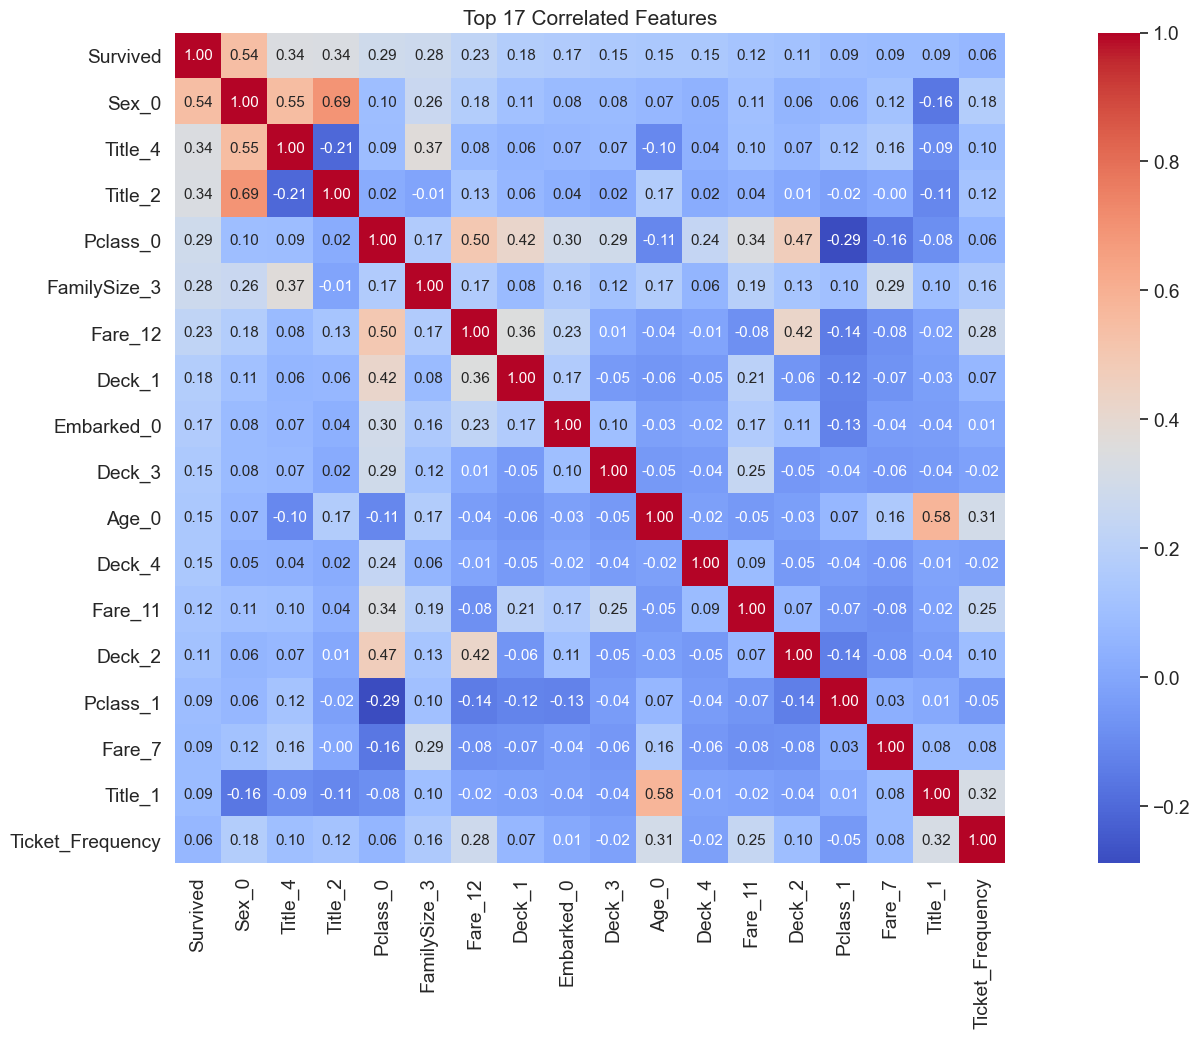

In [33]:
# plot one of the different heatmaps we chose in the last cell
plt.figure(figsize=(24,11))
sns.set(font_scale=1.25)

# i = random.choice(range(len(feats)))

cols = ['Survived'] + feats[6]
# cm = np.corrcoef(train_dummy[cols].values.T)
hm = sns.heatmap(
    train_dummy[cols].corr(),
    cbar = True,
    annot = True,
    square = True,
    fmt = '.2f',
    cmap = 'coolwarm',
    yticklabels = cols,
    xticklabels = cols,
    # title = f'Top {len(feats)-1} Correlated Features',
    annot_kws = {'size': 11}
)

hm.set(title=f'Top {len(cols)-1} Correlated Features')
plt.show()

### Hyper-Paramater Selection

We'll use GridSearchCV in order to choose the best hyper-paramaters for each model.

In [34]:
### ESTIMATORS ###
estimators = []
estimators += [{
    'name': 'DecisionTree',
    'model': DecisionTreeClassifier,
    'params': {
        'criterion': ['gini', 'entropy'],
        'class_weight': [None, 'balanced'],
    }
}]
estimators += [{
    'name': 'ExtraTree',
    'model': ExtraTreeClassifier,
    'params': {
        'criterion': ['gini', 'entropy'],
        'splitter': ['random', 'best'],
        'max_features': ['auto', 'sqrt', 'log2', None],
        'class_weight': [None, 'balanced'],
    }
}]
estimators += [{
    'name': 'SGD',
    'model': SGDClassifier,
    'params': {
        'shuffle': [True],
        # 'loss': ['log', 'hinge'],
        'loss': ['log'],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'alpha': [0.0001, 0.0002, 0.0003, 0.0005, 0.001, 0.002, 0.003],
    }
}]
estimators += [{
    'name': 'KNN',
    'model': KnnClassifier,
    'params': {
        'p': [1,2],
        'n_neighbors': gen_k(start=5, step=4, length=9),
    }
}]
estimators += [{
    'name': 'NBC',
    'model': GaussianNBC,
    'params': {}
}]
estimators += [{
    'name': 'LDA',
    'model': LDAClassifier,
    'params': {}
}]
### ESTIMATORS ###

### CV METHODS ###
l1o = LeavePOut(p=1)
fivefold = KFold(n_splits=5, shuffle=True, random_state=101)
tenfold = KFold(n_splits=10, shuffle=True, random_state=101)
### CV METHODS ###

scores = {}
(train_dummy, test_dummy) = pipeline.fit_transform(data)

for (i,d) in enumerate(estimators):
    model = d['model']
    params = d['params']
    model_name = d['name']
    scores[model_name] = pd.DataFrame(columns=['model_name', 'feats', 'n_feats', 'params', 'mean_train_score', 'mean_test_score'])

    display(Markdown(f'({i+1}/{len(estimators)}): {model_name}'))
    for cols in tqdm(feats):
        X = train_dummy[cols]
        y = train_dummy['Survived']
        grid_search = GridSearchCV(
            estimator = model(),
            param_grid = params,
            cv = tenfold.split(X),
            # cv = fivefold.split(X),
            # cv = l1o.split(X),
            scoring = 'accuracy',
            return_train_score = True
        ).fit(X, y)
        res = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
        res['model_name'] = [model_name]*len(res)
        res['feats'] = [cols]*len(res)
        res['n_feats'] = len(cols)
        scores[model_name] = pd\
            .concat([scores[model_name], res])\
            .sort_values(by=['mean_test_score', 'mean_train_score'], ascending=False)\
            .reset_index(drop=True)
    display(Markdown(f'best\_test\_score({model_name}): {np.max(scores[model_name]["mean_test_score"]):.4f}'))

display(Markdown('_**done**_'))

(1/6): DecisionTree

100%|██████████| 24/24 [00:05<00:00,  4.11it/s]


best\_test\_score(DecisionTree): 0.8261

(2/6): ExtraTree

100%|██████████| 24/24 [00:39<00:00,  1.66s/it]


best\_test\_score(ExtraTree): 0.8284

(3/6): SGD

100%|██████████| 24/24 [00:50<00:00,  2.09s/it]


best\_test\_score(SGD): 0.8328

(4/6): KNN

100%|██████████| 24/24 [02:35<00:00,  6.47s/it]


best\_test\_score(KNN): 0.8272

(5/6): NBC

100%|██████████| 24/24 [00:01<00:00, 16.90it/s]


best\_test\_score(NBC): 0.7924

(6/6): LDA

100%|██████████| 24/24 [00:02<00:00,  8.03it/s]


best\_test\_score(LDA): 0.8350

_**done**_

In [35]:
model_names = list(scores.keys())
display(Markdown('**Estimators:**'))
display(model_names)
# print('\nscores:\n', list(scores[model_names[0]].columns))

name = model_names[0]
display(Markdown(f'**{name}:**'))
scores[name]
# scores

**Estimators:**

['DecisionTree', 'ExtraTree', 'SGD', 'KNN', 'NBC', 'LDA']

**DecisionTree:**

,model_name,feats,n_feats,params,mean_train_score,mean_test_score
0,DecisionTree,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",29,"{'class_weight': None, 'criterion': 'entropy'}",0.892506,0.826117
1,DecisionTree,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",21,"{'class_weight': 'balanced', 'criterion': 'ent...",0.875172,0.821635
2,DecisionTree,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",25,"{'class_weight': None, 'criterion': 'entropy'}",0.885897,0.821598
3,DecisionTree,"[Sex_0, Title_4, Title_2, Pclass_0, FamilySize...",21,"{'class_weight': None, 'criterion': 'gini'}",0.889763,0.821573
4,DecisionTree,"[Sex_0, Title_4, Title_2, Pclass_0, FamilySize...",21,"{'class_weight': None, 'criterion': 'entropy'}",0.889763,0.821573
...,...,...,...,...,...,...
91,DecisionTree,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",41,"{'class_weight': 'balanced', 'criterion': 'ent...",0.930665,0.774395
92,DecisionTree,"[Sex_0, Title_4, Title_2, Pclass_0, FamilySize...",49,"{'class_weight': 'balanced', 'criterion': 'gini'}",0.932785,0.773283
93,DecisionTree,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",41,"{'class_weight': 'balanced', 'criterion': 'gini'}",0.930665,0.771074
94,DecisionTree,"[Sex_0, Title_4, Title_2, Pclass_0, FamilySize...",9,"{'class_weight': 'balanced', 'criterion': 'gini'}",0.788378,0.762085


Next up is plotting our loss functions and estimators.

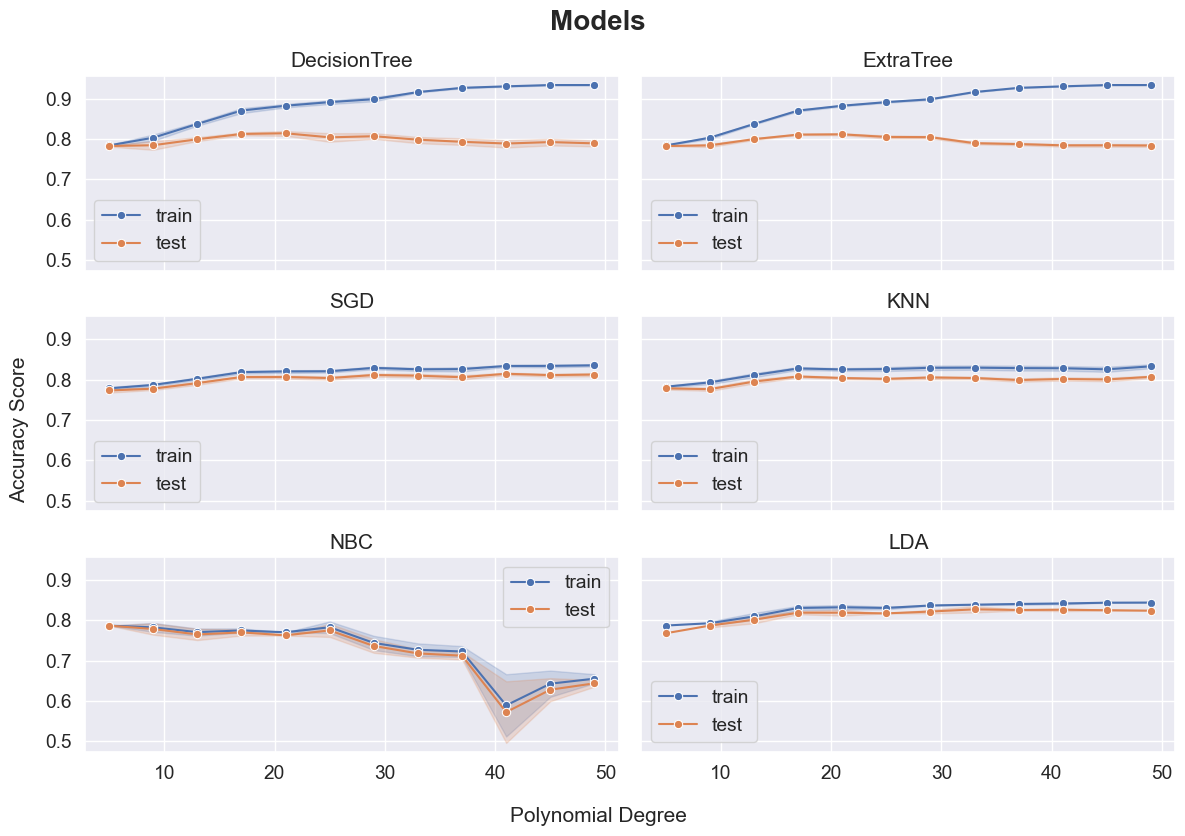

In [36]:
(fig, axs) = plt.subplots(nrows=int(np.ceil(len(model_names)/2)), ncols=2, sharex=True, sharey=True, figsize=(12,8))
axs = axs.flatten().tolist()
# fig.set_size_inches(15, 8)
fig.text(0.5, 1, 'Models', ha='center', weight='bold', fontsize='20')
fig.text(0.5, 0.01, 'Polynomial Degree', ha='center')
fig.text(0.01, 0.5, 'Accuracy Score', va='center', rotation='vertical')

for name in model_names:
    # plt.figure(figsize=(15,8))
    model_scores = scores[name]
    ax = axs.pop(0)

    #train
    g = sns.lineplot(
        x = 'n_feats',
        y = 'mean_train_score',
        data = model_scores,
        marker = 'o',
        ax = ax
    )
    
    #test
    g = sns.lineplot(
        x = 'n_feats',
        y = 'mean_test_score',
        data = model_scores,
        marker = 'o',
        ax = ax
    )

    #infos
    ax.legend(['train', 'test'])#, fontsize='medium')    
    g.set(
        xlabel = ' ',
        ylabel = ' ',
        title = name,
    )

fig.tight_layout()
plt.show()

Every `scores` dataframe is sorted by `['mean_test_score', 'mean_train_score']`.  
So the first row in every `scores` dataframe is the best score that specific model got.  

Now we're going to need to choose the best hyper-paramaters for each estimator.  
Let's go over them in a clean df, each line is the best hyper-paramaters for that specific estimator.  

In [37]:
estimators_df = pd.DataFrame(columns=['model_name', 'feats', 'n_feats', 'params', 'mean_train_score', 'mean_test_score'])

for name in model_names:
    best_score = scores[name].iloc[[0]]
    estimators_df = pd\
        .concat([estimators_df, best_score])\
        .sort_values(by=['mean_test_score', 'mean_train_score'], ascending=False)\
        .reset_index(drop=True)

estimators_df

,model_name,feats,n_feats,params,mean_train_score,mean_test_score
0,LDA,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",33,{},0.839258,0.835031
1,SGD,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",29,"{'alpha': 0.002, 'loss': 'log', 'penalty': 'l2...",0.841875,0.832809
2,ExtraTree,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",29,"{'class_weight': None, 'criterion': 'entropy',...",0.892506,0.828365
3,KNN,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",17,"{'n_neighbors': 21, 'p': 1}",0.832524,0.827179
4,DecisionTree,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",29,"{'class_weight': None, 'criterion': 'entropy'}",0.892506,0.826117
5,NBC,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",9,{},0.793491,0.792409


### Ensembles

Now for each hyper-paramater set we'll try different types of ensembles (Boosting vs Bagging) and then choose the best overall model.

In [38]:
def get_model_class(model_name):
    if model_name == 'DecisionTree':
        return DecisionTreeClassifier
    elif model_name == 'ExtraTree':
        return ExtraTreeClassifier
    elif model_name == 'SGD':
        return SGDClassifier
    elif model_name == 'KNN':
        return KnnClassifier
    elif model_name == 'NBC':
        return GaussianNBC
    elif model_name == 'LDA':
        return LDAClassifier
    elif model_name == 'bagging':
        return BaggingClassifier
    elif model_name == 'AdaBoost':
        return AdaBoostClassifier
    elif model_name == 'GradientBoosting':
        return GradientBoostingClassifier

def gen_estimators(df):
    estimators = []
    for (i,row) in df.iterrows():
        estimator = get_model_class(row['model_name'])
        estimator = estimator(**row['params'])
        cols = row['feats']
        estimators += [{'estimator': estimator, 'feats': cols}]
    return estimators

# gen_estimators(estimators_df)[1]
# estimators[5]

In [39]:
### ESTIMATORS ###
estimators = []
# ada boosting
# we need base models that support `sample_weight`, the only model we used which supports that is `SGDClassifier`.
for item in gen_estimators(estimators_df):
    if isinstance(item['estimator'], (SGDClassifier, DecisionTreeClassifier, ExtraTreeClassifier)):
        estimators += [{
        'name': 'AdaBoost',
        'model': AdaBoostClassifier,
        'feats': item['feats'],
        'params': {
            'base_estimator': [item['estimator']],
            'n_estimators': [25,50,75,100],
            'random_state': [101],
        }
    }]

# gradient boosting
for item in gen_estimators(estimators_df):
    estimators += [{
    'name': 'GradientBoosting',
    'model': GradientBoostingClassifier,
    'feats': item['feats'],
    'params': {
        'init': [item['estimator']],
        'n_estimators': [50,75,100,125,150],
        'loss': ['deviance', 'exponential'],
        'max_depth': [3,5],
        'random_state': [101],
    }
}]

# bagging
for item in gen_estimators(estimators_df):
    estimators += [{
    'name': 'bagging',
    'model': BaggingClassifier,
    'feats': item['feats'],
    'params': {
        'base_estimator': [item['estimator']],
        'n_estimators': [25,50,75,100],
        'bootstrap': [True, False],
        'random_state': [101],
    }
}]
### ESTIMATORS ###

### CV METHODS ###
l1o = LeavePOut(p=1)
fivefold = KFold(n_splits=5, shuffle=True, random_state=101)
tenfold = KFold(n_splits=10, shuffle=True, random_state=101)
### CV METHODS ###

scores = pd.DataFrame(columns=['model_name', 'feats', 'n_feats', 'params', 'mean_train_score', 'mean_test_score'])
(train_dummy, test_dummy) = pipeline.fit_transform(data)

for d in tqdm(estimators):
    model = d['model']
    params = d['params']
    model_name = d['name']
    cols = d['feats']

    X = train_dummy[cols]
    y = train_dummy['Survived']
    grid_search = GridSearchCV(
        estimator = model(),
        param_grid = params,
        cv = tenfold.split(X),
        # cv = fivefold.split(X),
        # cv = l1o.split(X),
        scoring = 'accuracy',
        return_train_score = True
    ).fit(X, y)
    res = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
    res['model_name'] = [model_name]*len(res)
    res['feats'] = [cols]*len(res)
    res['n_feats'] = len(cols)
    scores = pd\
        .concat([scores, res])\
        .sort_values(by=['mean_test_score', 'mean_train_score'], ascending=False)\
        .reset_index(drop=True)

display(Markdown('_**done**_'))

100%|██████████| 15/15 [04:46<00:00, 19.07s/it]


_**done**_

Every `scores` dataframe is sorted by `['mean_test_score', 'mean_train_score']`.  

So the first row in every `scores` dataframe is the best score that specific model got.

In [40]:
# ensembles scores
display(scores.head())

,model_name,feats,n_feats,params,mean_train_score,mean_test_score
0,GradientBoosting,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",29,"{'init': SGDClassifier(alpha=0.002, loss='log'...",0.881783,0.839588
1,GradientBoosting,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",29,"{'init': SGDClassifier(alpha=0.002, loss='log'...",0.889139,0.836205
2,bagging,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",33,{'base_estimator': LinearDiscriminantAnalysis(...,0.839258,0.835031
3,bagging,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",33,{'base_estimator': LinearDiscriminantAnalysis(...,0.839258,0.835031
4,bagging,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",33,{'base_estimator': LinearDiscriminantAnalysis(...,0.839258,0.835031


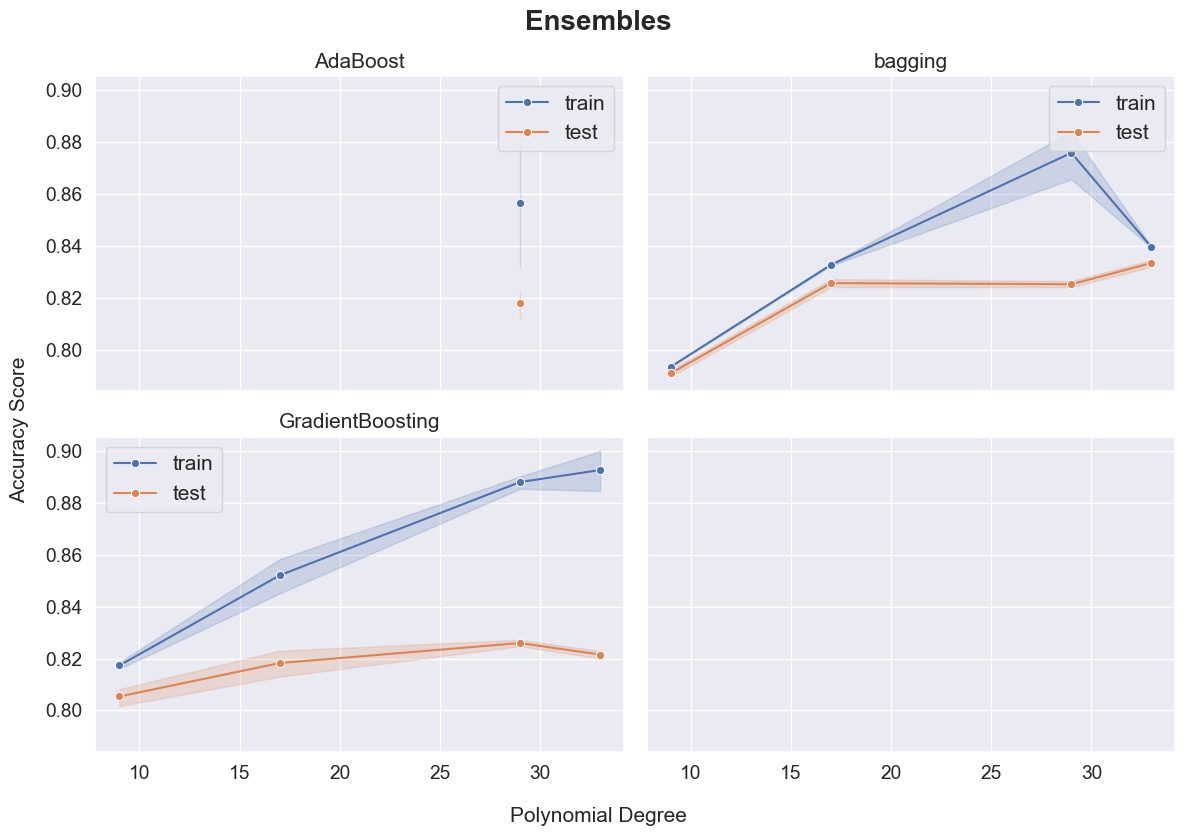

In [41]:
model_names = set(scores['model_name'])

(fig, axs) = plt.subplots(nrows=int(np.ceil(len(model_names)/2)), ncols=2, sharex=True, sharey=True, figsize=(12,8))
axs = axs.flatten().tolist()
# fig.set_size_inches(12, 8)
fig.text(0.5, 1, 'Ensembles', ha='center', weight='bold', fontsize='20')
fig.text(0.5, 0.01, 'Polynomial Degree', ha='center')
fig.text(0.01, 0.5, 'Accuracy Score', va='center', rotation='vertical')

for name in model_names:
    # plt.figure(figsize=(15,8))
    model_scores = scores[scores['model_name'] == name]
    ax = axs.pop(0)

    #train
    g = sns.lineplot(
        x = 'n_feats',
        y = 'mean_train_score',
        data = model_scores,
        marker = 'o',
        ax = ax
    )
    
    #test
    g = sns.lineplot(
        x = 'n_feats',
        y = 'mean_test_score',
        data = model_scores,
        marker = 'o',
        ax = ax
    )

    #infos
    ax.legend(['train', 'test'], fontsize='medium')    
    g.set(
        xlabel = ' ',
        ylabel = ' ',
        title = name,
    )

fig.tight_layout()
plt.show()

In [42]:
# all estimators scores
estimators_df = pd\
        .concat([estimators_df, scores])\
        .sort_values(by=['mean_test_score', 'mean_train_score'], ascending=False)\
        .reset_index(drop=True)

display(estimators_df.head())

,model_name,feats,n_feats,params,mean_train_score,mean_test_score
0,GradientBoosting,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",29,"{'init': SGDClassifier(alpha=0.002, loss='log'...",0.881783,0.839588
1,GradientBoosting,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",29,"{'init': SGDClassifier(alpha=0.002, loss='log'...",0.889139,0.836205
2,LDA,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",33,{},0.839258,0.835031
3,bagging,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",33,{'base_estimator': LinearDiscriminantAnalysis(...,0.839258,0.835031
4,bagging,"[Title_3, Sex_0, Sex_1, Title_4, Title_2, Pcla...",33,{'base_estimator': LinearDiscriminantAnalysis(...,0.839258,0.835031


In [43]:
row = estimators_df.iloc[0]
display(Markdown('**Best Overall Model**'))
display(Markdown(f"{row['model_name']}:  \n{row['params']}"))
display(Markdown(f"test_score:  \n{row['mean_test_score']:.4f}"))

**Best Overall Model**

GradientBoosting:  
{'init': SGDClassifier(alpha=0.002, loss='log'), 'loss': 'exponential', 'max_depth': 5, 'n_estimators': 50, 'random_state': 101}

test_score:  
0.8396

### Confusion Matrix & KPIs

This next section is all about the Confusion Matrix and the KPIs that are calculated from the matrix.  

Let's start by displaying the Confusion Matrix.

In [44]:
# get the best estimator
row = estimators_df.iloc[0]
cols = row['feats']
estimator = get_model_class(row['model_name'])
estimator = estimator(**row['params'])

# get a clean train & test DFs
(train_dummy, test_dummy) = pipeline.fit_transform(data)
(X_train, X_test, y_train, y_test) = train_test_split(train_dummy[cols], train_dummy['Survived'], test_size=0.33, random_state=69) #nice

# train the model on the entire train set
# display(X_train.isna().sum())
model = estimator.fit(X_train, y_train)

# predict the test set
y_pred = model.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))

cm

,0,1
0,165,22
1,30,78


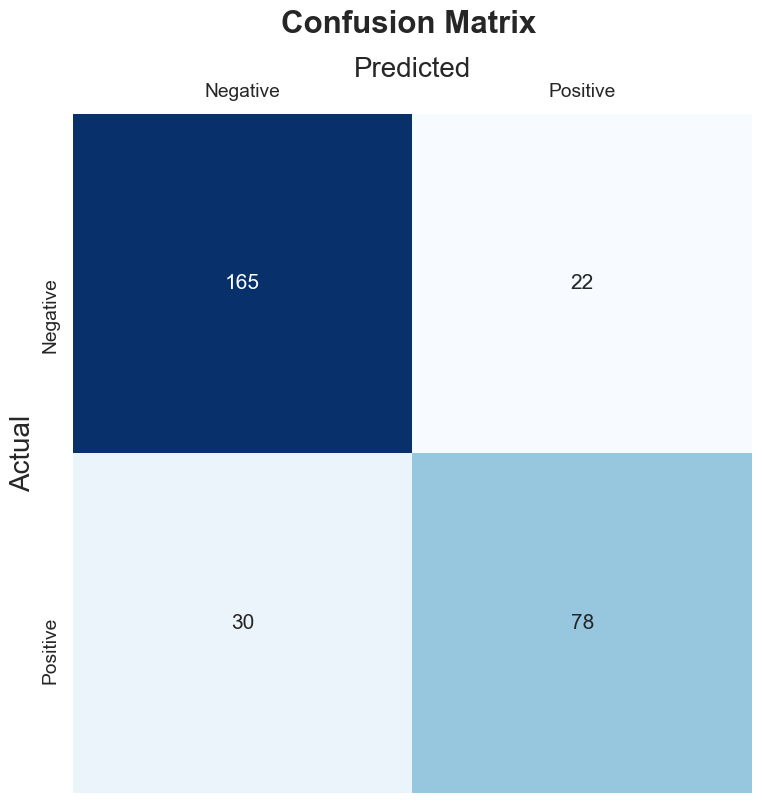

In [45]:
fig, ax = plt.subplots(figsize=(15,9))
sns.set(font_scale=1.25)

ticks = ['Negative', 'Positive']
g = sns.heatmap(
    cm,
    cbar = False,
    annot = True,
    square = True,
    fmt = '.0f',
    cmap = plt.cm.Blues,
    yticklabels = ticks,
    xticklabels = ticks,
)

fig.text(0.51, 0.97, 'Confusion Matrix', ha='center', fontsize=22.5, weight='bold')
plt.title('')
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
ax.xaxis.set_label_position('top')
plt.tick_params(labelbottom=False, labeltop=True)
plt.show()

In [46]:
def precision(cm):
    tn, fp, fn, tp = cm.to_numpy().ravel()
    return tp/(tp+fp)

def recall(cm):
    tn, fp, fn, tp = cm.to_numpy().ravel()
    return tp/(tp+fn)

def specificity(cm):
    tn, fp, fn, tp = cm.to_numpy().ravel()
    return tn/(tn+fp)

def fpr(cm):
    tn, fp, fn, tp = cm.to_numpy().ravel()
    return fp/(fp+tn)

def accuracy(cm):
    tn, fp, fn, tp = cm.to_numpy().ravel()
    return (tp+tn)/(tp+tn+fp+fn)

def f1(cm):
    precision_calc = precision(cm)
    recall_calc = recall(cm)
    return (2*precision_calc*recall_calc)/(precision_calc+recall_calc)

def balanced_accuracy(cm):
    recall_calc = recall(cm)
    specificity_calc = specificity(cm)
    return (recall_calc+specificity_calc)/2

In [47]:
cm_scores = pd.DataFrame(index=['precision', 'recall', 'specificity', 'fpr', 'accuracy', 'balanced_accuracy', 'f1'], columns=['score'])
cm_scores.index.name = 'KPI'

cm_scores.loc['precision'] = precision(cm)
cm_scores.loc['recall'] = recall(cm)
cm_scores.loc['specificity'] = specificity(cm)
cm_scores.loc['fpr'] = fpr(cm)
cm_scores.loc['accuracy'] = accuracy(cm)
cm_scores.loc['balanced_accuracy'] = balanced_accuracy(cm)
cm_scores.loc['f1'] = f1(cm)

cm_scores

,score
KPI,
precision,0.78
recall,0.722222
specificity,0.882353
fpr,0.117647
accuracy,0.823729
balanced_accuracy,0.802288
f1,0.75


## Testing

Let's choose the best model and try and predict the actual test data from kaggle.

In [48]:
# get the best estimator
row = estimators_df.iloc[0]
cols = row['feats']
estimator = get_model_class(row['model_name'])
estimator = estimator(**row['params'])

# get a clean train & test DFs
(train_dummy, test_dummy) = pipeline.fit_transform(data)

# train the model on the entire train set
model = estimator.fit(train_dummy[cols], train_dummy['Survived'])

# predict the test set
y_pred = model.predict(test_dummy[cols])

pred = pd.DataFrame(
    y_pred,
    columns = ['Survived'],
    index = test.index
)

display(pred)

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0


In [49]:
# pred.to_csv('pred.csv')

## Summary

### Screenshots

![submissions](./submissions.png)  

![leaderboards](./leaderboards.png)

### Conclusions

I had a lot of fun making this notebook, I feel like im getting better at orginizing my thought process and transfaring them into a notbook.  
I really took pride in my GridSearchCV part and the pipeline orginization.  

At the end I couldn't improve my overall score in the Kaggle competition, I think it may be because my feature engineering was a bit lacking.  
But at least I still had fun :)

## References

1. [Advanced Feature Engineering](https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial)
2. [Titanic: A complete approach to Top Rankings](https://www.kaggle.com/pedrodematos/titanic-a-complete-approach-to-top-rankings)
3. [Awesome Visualization with Titanic Dataset](https://www.kaggle.com/subinium/awesome-visualization-with-titanic-dataset)
4. My `house-prices` notebook